##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neuron Interaction Grids

This notebook uses  [**Lucid**](https://github.com/tensorflow/lucid) to produce grids showing how neurons different neurons interact.

This is a relatively small variation on the ideas explored in the [Feature Visualization article](https://distill.pub/2017/feature-visualization/) when it talks a [neuron interactions](https://distill.pub/2017/feature-visualization/#interaction) and the [corresponding notebook](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/feature-visualization/neuron_interaction.ipynb).

This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install, Import, Load Model

In [ ]:
# Install Lucid
!pip install --quiet "lucid>=0.3.11"
#!pip install --quiet --upgrade-strategy=only-if-needed git+https://github.com/tensorflow/lucid.git

In [3]:
# Import libraries
import numpy as np
import tensorflow as tf
import scipy.ndimage as nd

from google.colab import files

import lucid.modelzoo.vision_models as models
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
from lucid.misc.io import show, load
from lucid.misc.io.reading import read

In [4]:
# Import the InceptionV1 (GoogLeNet) model from the Lucid modelzoo

model = models.InceptionV1()
model.load_graphdef()

In [5]:
# You may need to fiddle with hyperparameters to get this code to work on
# differnet neurons. In particular, see the blur coefficient and the weights
# on the different paramaterization components.

def neuron_interaction_grid(neurons, W = 128):
  
  N = len(neurons)
  
  with tf.Graph().as_default(), tf.compat.v1.Session() as sess:
    
    shared = param.fft_image((1, W, W, 3)) + param.lowres_tensor((1, W, W, 3), (1, W//4, W//4, 3))
    pure = param.fft_image((N, W, W, 3))
    blend = param.fft_image((N*N, W, W, 3))
    
    pure_mix = lambda n,m: (tf.stop_gradient if n != m else lambda x: x)(pure[n] + pure[m])/2.
    get_blend = lambda n,m: blend[N*min(n,m) + max(n,m)] if n != m else pure[n]
    
    combined = [pure_mix(n,m) + get_blend(n,m) + 2.0*shared[0]
                for n in range(N) for m in range(N)]
    images = param.to_valid_rgb(0.5*tf.stack(combined), decorrelate=True)
    
    obj_f = lambda n, i: 0.2*objectives.channel(*neurons[n], batch = i) + objectives.neuron(*neurons[n], batch = i)
    obj = sum([ obj_f(n, N*n+m) + obj_f(m, N*n+m) for n in range(N) for m in range(N)])
    obj += -10.0*objectives.blur_input_each_step()

    T = render.make_vis_T(model, obj, images)
    loss, vis_op, t_image = T("loss"), T("vis_op"), T("input")
    
    tf.compat.v1.global_variables_initializer().run()
    for i in range(512):
      _ = sess.run([vis_op])
      if (i+1) % 128 == 0:
        result = t_image.eval()
        grid = [[result[N*n+m][15:-25, 15:-25] for n in range(N)] for m in range(N)]
        show(np.hstack(np.hstack(grid)))

# Interaction Grids

In the following visualizations, each column and row corresponds to a neuron. Each image is the combination of the row neuron and the column neuron. Aligned paramterization is used to encourage the images to align.


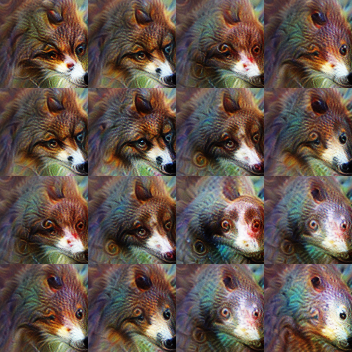


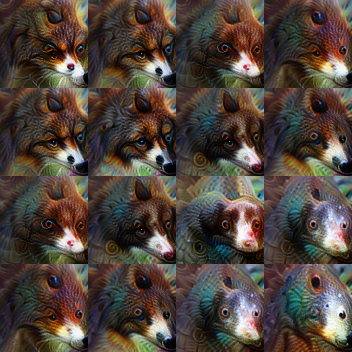


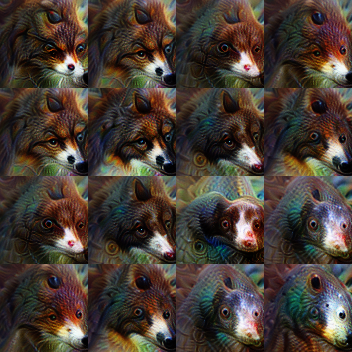


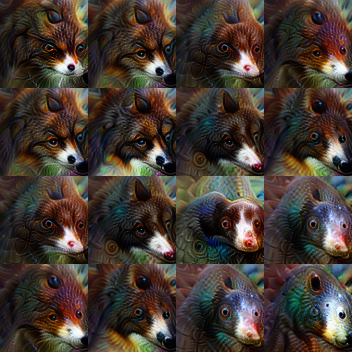

In [6]:
# Snouts
neurons = [
    ("mixed4d", 493),
    ("mixed4d", 477),
    ("mixed4d", 488),
    ("mixed4d", 486),
]

neuron_interaction_grid(neurons)